In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.stats
import scipy.optimize

In [159]:
# Data extracted from 14845.full.pdf figure 3C, first trial
# (https://www.jneurosci.org/content/34/45/14845.short)
data = np.fromstring("""3.55555555556  1
53.3333333333  1
60.4444444444  1
101.333333333  1
115.555555556  1
152.888888889  1
158.222222222  1
192  1
209.777777778  1
211.555555556  1
241.777777778  1
256  1
261.333333333  1
263.111111111  1.00000000000
266.666666667  1.85008517888
272  5.25042589438
275.555555556  9.50085178876
277.333333333  13.7512776831
279.111111111  15.4514480409
282.666666667  21.402044293
284.444444444  23.9522998296
288  29.0528109029
291.555555556  35.003407155
293.333333333  40.1039182283
296.888888889  45.2044293015
300.444444444  49.4548551959
304  51.1550255537
312.888888889  52.8551959114
318.222222222  52.8551959114
339.555555556  52.8551959114
353.777777778  51.1550255537
362.666666667  50.3049403748
369.777777778  48.604770017
376.888888889  46.9045996593
384  46.9045996593
392.888888889  46.0545144804
398.222222222  46.0545144804
400  46.0545144804""", sep="  ").reshape(-1, 2).T

# Extend the range to include 0,0
data[0, 0] = 0.0

# Normalise the time to seconds
data[0, :] /= 1000.0

# Normalise the maximum to 1.0
data[1, :] /= np.max(data[1])

# Add an idealised trajectory for opening the eye again
data = np.concatenate(
    (data,
     [[0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
      [0.6, 0.4, 0.2, 0.05, 0.0, 0.0]]), axis=1)

# Unconditioned timestamps
us_ts = data[0]
us_ys = data[1]

# Generate a spline of that data and compute its derivative
f = scipy.interpolate.BSpline(*scipy.interpolate.splrep(us_ts, us_ys, k=2, s=4e-3))
df = f.derivative()

# Split the derivative into a positive and a negative branch
ts = np.linspace(0, 1.0, 1000)
dfp = np.clip(df(ts), 0, None)
dfm = np.clip(-df(ts), 0, None)

# Fit two skewed gaussians to dfp and dfm
def skewnorm(x, mu, a, std, s):
    return (s * std) * scipy.stats.skewnorm.pdf(x, a, mu, std)

def fit_skewed_gaussian(xs, ys, p0):
    return scipy.optimize.curve_fit(skewnorm, xs, ys, p0, maxfev=10000)[0]

dfp_p = fit_skewed_gaussian(ts, dfp, (ts[np.argmax(dfp)], 2.0, 0.02, 100.0))
dfm_p = fit_skewed_gaussian(ts, dfm, (ts[np.argmax(dfm)], 2.0, 0.2, 10.0))

df_rec = skewnorm(ts, *dfp_p) - skewnorm(ts, *dfm_p)
f_rec = np.cumsum(df_rec) * 1e-3

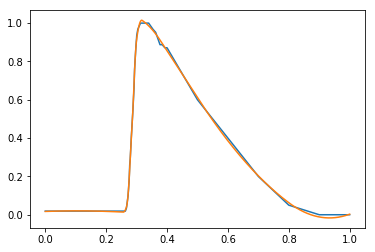

In [160]:
fig, ax = plt.subplots()
ax.plot(us_ts, us_ys)
ax.plot(ts, f(ts))

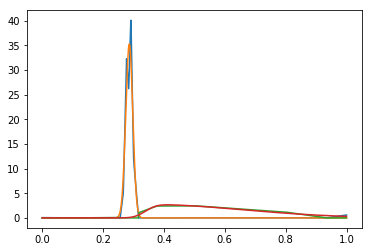

In [161]:
ts2 = np.linspace(0.0, 1.0, 1000)
fig, ax = plt.subplots()
ax.plot(ts, dfp)
ax.plot(ts2, skewnorm(ts2, *dfp_p))
ax.plot(ts, dfm)
ax.plot(ts2, skewnorm(ts2, *dfm_p))

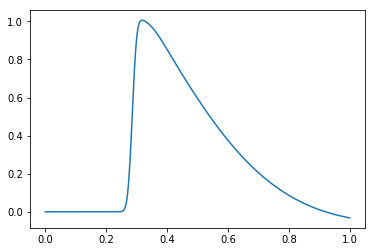

In [162]:
fig, ax = plt.subplots()
ax.plot(ts, f_rec)

In [163]:
dfp_p, dfm_p

(array([ 2.91044622e-01, -5.67730226e-01,  1.25624730e-02,  8.12206584e+01]),
 array([ 0.33981309, 10.7624779 ,  0.3168123 ,  3.44985036]))